# Getting DATA From AAPL Using Yahoo API

In [62]:
# First, install the required libraries
# Execute the following command in the command line or terminal:
# pip install yfinance pandas_ta

import yfinance as yf
import pandas as pd
import pandas_ta as ta

# 1. Download historical data for AAPL stock
stock_data = yf.download("AAPL", start="2020-01-01", end="2023-01-01")
stock_data.to_csv("AAPL_stock_data.csv")  # Save as CSV file

# 2. Load the data
stock_data = pd.read_csv("AAPL_stock_data.csv")

# Generate a date column and add it to the data
# Assume the data is arranged by consecutive trading days
stock_data.insert(0, 'Date', pd.date_range(start="2020-01-02", periods=len(stock_data), freq='B'))

# Set the date column as the index
stock_data.set_index('Date', inplace=True)

# Check the data format
print(stock_data.head())

# Save the modified data to a new CSV file
stock_data.to_csv("AAPL_stock_data_with_date.csv")

# 3. Reload the modified data
stock_data = pd.read_csv("AAPL_stock_data_with_date.csv", index_col='Date', parse_dates=True)

# Ensure all columns are numeric types, especially those needed for calculations
columns_to_convert = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in columns_to_convert:
    stock_data[col] = pd.to_numeric(stock_data[col], errors='coerce')

# Remove rows with missing values
stock_data.dropna(subset=columns_to_convert, inplace=True)

# Calculate MACD
macd = ta.macd(stock_data['Close'], fast=12, slow=26, signal=9)
stock_data['MACD'] = macd['MACD_12_26_9']
stock_data['MACD_Signal'] = macd['MACDs_12_26_9']
stock_data['MACD_Hist'] = macd['MACDh_12_26_9']

# Calculate KDJ
kdj = ta.stoch(stock_data['High'], stock_data['Low'], stock_data['Close'], k=14, d=3)
stock_data['K'] = kdj['STOCHk_14_3_3']
stock_data['D'] = kdj['STOCHd_14_3_3']
stock_data['J'] = 3 * stock_data['K'] - 2 * stock_data['D']  # Calculate J in KDJ

# Calculate RSI
stock_data['RSI'] = ta.rsi(stock_data['Close'], length=14)

# Check the results
print(stock_data[['Close', 'MACD', 'MACD_Signal', 'MACD_Hist', 'K', 'D', 'J', 'RSI']].head())

# Save data to a new CSV file
stock_data.to_csv("AAPL_stock_data_with_indicators.csv")


[*********************100%***********************]  1 of 1 completed

                                Price          Adj Close              Close  \
Date                                                                          
2020-01-02                     Ticker               AAPL               AAPL   
2020-01-03                       Date                NaN                NaN   
2020-01-06  2020-01-02 00:00:00+00:00  72.87610626220703   75.0875015258789   
2020-01-07  2020-01-03 00:00:00+00:00  72.16761779785156  74.35749816894531   
2020-01-08  2020-01-06 00:00:00+00:00   72.7426528930664  74.94999694824219   

                         High                Low               Open     Volume  
Date                                                                            
2020-01-02               AAPL               AAPL               AAPL       AAPL  
2020-01-03                NaN                NaN                NaN        NaN  
2020-01-06   75.1500015258789  73.79750061035156  74.05999755859375  135480400  
2020-01-07   75.1449966430664            

# visual representation of the AAPL stock price along with the MACD and RSI indicators

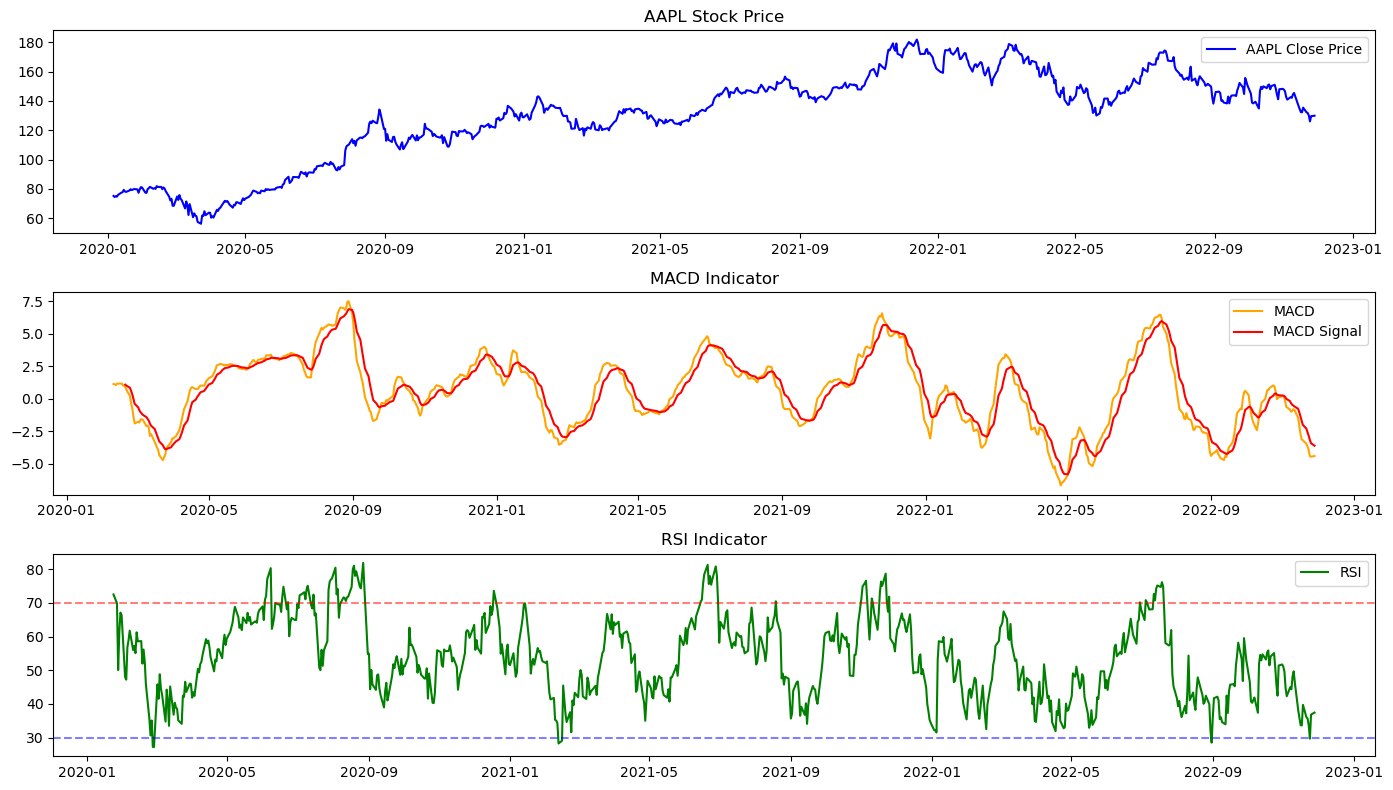

In [37]:
import matplotlib.pyplot as plt

# Plotting the stock price and indicators
plt.figure(figsize=(14, 8))

# Stock Price
plt.subplot(3, 1, 1)
plt.plot(stock_data['Close'], label='AAPL Close Price', color='blue')
plt.title('AAPL Stock Price')
plt.legend()

# MACD
plt.subplot(3, 1, 2)
plt.plot(stock_data['MACD'], label='MACD', color='orange')
plt.plot(stock_data['MACD_Signal'], label='MACD Signal', color='red')
plt.title('MACD Indicator')
plt.legend()

# RSI
plt.subplot(3, 1, 3)
plt.plot(stock_data['RSI'], label='RSI', color='green')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')
plt.axhline(30, linestyle='--', alpha=0.5, color='blue')
plt.title('RSI Indicator')
plt.legend()

plt.tight_layout()
plt.show()


# Data Modeling (predicting stock price movement)

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Create a target variable (1 for price increase, 0 for price decrease)
stock_data['Target'] = (stock_data['Close'].shift(-1) > stock_data['Close']).astype(int)

# Select features and target
features = stock_data[['MACD', 'K', 'D', 'RSI']]
target = stock_data['Target'].dropna()

# Drop rows with NaN values in both features and target
features = features.dropna()
target = target.loc[features.index] 

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=False)

# Train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))



Accuracy: 0.48299319727891155
              precision    recall  f1-score   support

           0       0.55      0.14      0.22        78
           1       0.47      0.87      0.61        69

    accuracy                           0.48       147
   macro avg       0.51      0.51      0.42       147
weighted avg       0.51      0.48      0.41       147

